# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torch.nn as nn
import os
from birdlib import utils

In [2]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [3]:
DATASET_NAME = "dataset"
MODEL_NAME = 'DeeperCNN'
DATASET_VAR = 'augm'

In [4]:
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
VALID_PATH = f"{DATASET_PATH}/valid"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_PATH = f'./models/{MODEL_NAME}'

# Create Dataset Config

In [5]:
def create_dataset_config(dataset_name, config_file_name='dataset_config.json'):
    saving_path = f"utils/{dataset_name}/{config_file_name}"
    if os.path.exists(saving_path):
        print("Dataset config already created!")
        with open(saving_path) as f:
            return json.load(f)

    mappings = utils.get_mappings(TRAIN_PATH)
    samples = utils.collect_samples(TRAIN_PATH, VALID_PATH, TEST_PATH, mappings)

    dataset_config = {
        "mappings": mappings,
        "samples": samples
    }
    with open(saving_path, "w") as f:
        json.dump(dataset_config, f)
    print("Saved new dataset config")
    return dataset_config

In [6]:
dataset_config = create_dataset_config(DATASET_NAME, f'dataset_config_{DATASET_VAR}.json')
mappings = dataset_config["mappings"]

Saved new dataset config


## Load the model

In [7]:
model_class = utils.load_model_class(MODEL_NAME)
model = model_class(len(mappings))

# Spectograms Creation

In [8]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_VALID_PATH = f"{DATASET_PATH}/valid_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_VALID_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
utils.specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
utils.specs_generation(VALID_PATH, SPECS_VALID_PATH, dataset_config['mappings'])
utils.specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Rain
Processing: Vegetation
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: None
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Phylloscopus collybita_Common Chiffchaff
Processing: Wind
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Pecking
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Turdus philomelos_Song Thrush


Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Rain
Processing: Vegetation
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: None
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Phylloscopus collybita_Common Chiffchaff
Processing: Wind
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Pecking
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Turdus philomelos_Song Thrush
Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulu

'✅ Spettrogrammi generati e salvati.'

# Model

In [9]:
def train_model(dataset_config, model, epochs=10, batch_size=100, lr=1e-5, patience=3, early_stop_patience=5, print_freq=100, load_weights=False, checkpoint_name='checkpoint.pth'):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {MODEL_NAME} on: {device}")

    print("Loading training data...")
    train_loader = utils.get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")

    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=patience, threshold=1e-4
    )
    history_loss = []
    best_loss = float("inf")
    starting_epoch = 0

    saving_path = f'models/{MODEL_NAME}/{checkpoint_name}'
    if load_weights:
        if not os.path.exists(saving_path):
            print("No weights found!")
            return None
        checkpoint = torch.load(saving_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history_loss = checkpoint['history_loss']
        best_loss = checkpoint['avg_loss']
        starting_epoch = len(history_loss)
        epochs += starting_epoch
        print(f"Model Loaded!")
    print(f"Starting from epoch {starting_epoch} for {epochs} epochs")
        
    early_stop_counter = 0
    for epoch in range(epochs):
        epoch += starting_epoch
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch = len(history_loss)

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        avg_loss = running_loss / len(train_loader)
        history_loss.append(running_loss)
        scheduler.step(running_loss)

        np.save(f'models/{MODEL_NAME}/history_loss_{DATASET_VAR}.npy', history_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stop_counter = 0
            print(f"💾 Saving improved model at epoch {epoch+1} with avg_loss={avg_loss:.5f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'avg_loss': avg_loss,
                'history_loss': history_loss
            }, saving_path)
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement — early stop counter: {early_stop_counter}/{early_stop_patience}")

        print(f"🔁 Epoch {epoch+1} completed - Avg loss: {avg_loss:.7f} - LR: {optimizer.param_groups[0]['lr']:.1e}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🚨 Early stopping triggered after {early_stop_patience} epochs without improvement.")
            break

    print("✅ Training completed")
    return model


In [ ]:
model = train_model(dataset_config, model, epochs=200, batch_size=64, lr=1e-3, load_weights=False, checkpoint_name=f'checkpoint_{DATASET_VAR}.pth')

Training DeeperCNN on: cuda
Loading training data...


Loaded!
Starting from epoch 0 for 200 epochs

🎯 Starting epoch 1/200
Epoch: [0][0/515], Loss: 0.70051
Epoch: [0][100/515], Loss: 0.20028
Epoch: [0][200/515], Loss: 0.19597
Epoch: [0][300/515], Loss: 0.18165
Epoch: [0][400/515], Loss: 0.15651
Epoch: [0][500/515], Loss: 0.12914
💾 Saving improved model at epoch 1 with avg_loss=0.19085
🔁 Epoch 1 completed - Avg loss: 0.1908546 - LR: 1.0e-03

🎯 Starting epoch 2/200
Epoch: [1][0/515], Loss: 0.14113
Epoch: [1][100/515], Loss: 0.12855
Epoch: [1][200/515], Loss: 0.12933
Epoch: [1][300/515], Loss: 0.12788
Epoch: [1][400/515], Loss: 0.11876
Epoch: [1][500/515], Loss: 0.11464
💾 Saving improved model at epoch 2 with avg_loss=0.12481
🔁 Epoch 2 completed - Avg loss: 0.1248056 - LR: 1.0e-03

🎯 Starting epoch 3/200
Epoch: [2][0/515], Loss: 0.12662
Epoch: [2][100/515], Loss: 0.13424
Epoch: [2][200/515], Loss: 0.10468
Epoch: [2][300/515], Loss: 0.10264
Epoch: [2][400/515], Loss: 0.10825
Epoch: [2][500/515], Loss: 0.09913
💾 Saving improved model at epoch 

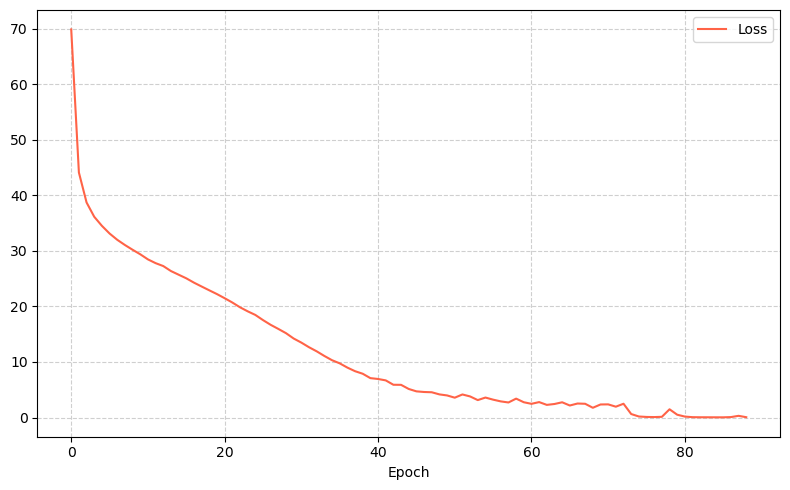

In [ ]:
history_loss = np.load(f'models/{MODEL_NAME}/history_loss_{DATASET_VAR}.npy')
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
torch.cuda.empty_cache()
os.getpid()

31138